### Author : BlackViper(Harshit Saxena)
#### Created at 16:14:20 26-01-2018
______

In [2]:
# Loading packages
import os
import pandas as pd
import numpy as np
import datetime
from dateutil import parser
import dateutil
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
import pylab
from scipy.sparse import csr_matrix
import os.path as op
import nimfa as nf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
def importData(dataDir='/home/harshit/Desktop/Analytics/Dota'):
    
    Data = pd.read_csv(dataDir+"/preprocessedtrain4.csv")
    testdata = pd.read_csv(dataDir+"/preprocessedtest4.csv")
    Data['id'] = Data['id'].astype("category")            #converting into categorical variables
    Data['user_id'] = Data['user_id'].astype("category")
    Data['hero_id'] = Data['hero_id'].astype("category")
    testdata['id'] = testdata['id'].astype("category")            #converting into categorical variables
    testdata['user_id'] = testdata['user_id'].astype("category")
    testdata['hero_id'] = testdata['hero_id'].astype("category")
    Data = Data.dropna(how='any')
    return Data, testdata

In [4]:
lessuserid = pd.read_csv('/home/harshit/Desktop/Analytics/Dota/overfitting.csv')

In [5]:
lessuserid.columns = ['user_id']
lessuserid['user_id'] = lessuserid['user_id'].astype("category")
ll = lessuserid.user_id.values

In [6]:
data, testdata = importData()

In [7]:
data.head()

,hero_id,user_id,id,num_games,num_wins,kda_ratio,seqno,primary_attr_agi,primary_attr_int,primary_attr_str,...,role_Durable,role_Support,modeseq,meanseq,meankda10_hero,meankda_hero,winavg_hero,meankda_usr,winavg_usr,cluster_hero
0,74,1,1_74,304,185,3743.699732,1,0,1,0,...,0,0,1,4.740152,3673.086026,3880.256807,175.644645,3844.926356,111.700000,1
1,74,1796,1796_74,385,220,3765.292842,1,0,1,0,...,0,0,1,4.740152,3673.086026,3880.256807,175.644645,3292.245658,111.009185,1
2,74,940,940_74,48,30,2985.074627,6,0,1,0,...,0,0,1,4.740152,3673.086026,3880.256807,175.644645,3020.996520,32.400000,1
3,74,1862,1862_74,339,221,4471.565174,1,0,1,0,...,0,0,1,4.740152,3673.086026,3880.256807,175.644645,4249.237433,88.500000,1
4,74,2550,2550_74,180,113,4045.112782,9,0,1,0,...,0,0,1,4.740152,3673.086026,3880.256807,175.644645,3680.931263,66.195842,1


In [8]:
## Data Preprocessing...


In [9]:
data_10 = data[data.seqno == 10]
data_no10 = data[data.seqno != 10]

In [10]:
print('Splitting data.')    
train,test = train_test_split(data_10,test_size=0.8,random_state=1)
train = pd.concat([train,data_no10], axis = 0)

Splitting data.


In [11]:
print(train.shape)
print(test.shape)

(27339, 45)
(1676, 45)


In [12]:
def RMSE(y_pred,y_true):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def RMSE_matrix(prediction, test_mat):
    mask = test_mat>0; mask[mask==True]=1; mask[mask==False]=0
    prediction = np.multiply(prediction, mask)
    return (np.sum((prediction - test_mat)**2)/np.sum(mask))**0.5

In [13]:
def alspreprocess(ratingData, test, train):
    n_u = len(ratingData['user_id'].cat.categories)
    print n_u
    n_m = len(ratingData['hero_id'].cat.categories)+5
    print n_m
    test_col = np.array(test['user_id'].values)-1
    print test_col.max()
    test_row = np.array(test['hero_id'].values)-1
    print test_row.max()
    test_dat = np.array(test['kda_ratio'].values)
    train_col = np.array(train['user_id'].values)-1
    print train_col.max()
    train_row = np.array(train['hero_id'].values)-1
    print train_row.max()
    train_dat = np.array(train['kda_ratio'].values)
    train_mat = (csr_matrix((train_dat, (train_row, train_col)), shape=(n_m, n_u)).toarray()).T
    test_mat = (csr_matrix((test_dat, (test_row, test_col)), shape=(n_m, n_u)).toarray()).T
    return test_mat, train_mat

In [14]:
test_mat, train_mat = alspreprocess(data, test, train)

2992
120
2991
119
2991
119


In [47]:
als  = nf.Lsnmf(train_mat,seed="random_vcol",rank=300,max_iter = 50, beta = 0.5)
als_fit = als.factorize()
        
U = np.array(als_fit.basis())
V = np.array(als_fit.coef())
predictedMat = np.round(np.array(np.dot(U, V)),2)
trainRMSE = RMSE_matrix(predictedMat,train_mat)
testRMSE = RMSE_matrix(predictedMat,test_mat)
print "ALS\nTrain RMSE : %f  Test RMSE : %f"%(trainRMSE, testRMSE)

ALS
Train RMSE : 2669.151408  Test RMSE : 2621.447594


In [16]:
ranklist = [100,150,200,250,300,350,400,450,500]
betalist = [0.1,0.3,0.5,0.7,0.9]
for i in ranklist:
    for j in betalist:
        als  = nf.Lsnmf(train_mat,seed="random_vcol",rank=i,max_iter = 50, beta = j)
        als_fit = als.factorize()

        U = np.array(als_fit.basis())
        V = np.array(als_fit.coef())
        predictedMat = np.round(np.array(np.dot(U, V)),2)
        trainRMSE = RMSE_matrix(predictedMat,train_mat)
        testRMSE = RMSE_matrix(predictedMat,test_mat)
        print "ALS for % rank and %f beta\nTrain RMSE : %f  Test RMSE : %f"%(i, j, trainRMSE, testRMSE)

ALS for 100ank and 0.100000 beta
Train RMSE : 3135.381397  Test RMSE : 3098.429894
ALS for 100ank and 0.300000 beta
Train RMSE : 3064.939255  Test RMSE : 3028.115669
ALS for 100ank and 0.500000 beta
Train RMSE : 2956.284784  Test RMSE : 2919.099541
ALS for 100ank and 0.700000 beta
Train RMSE : 3137.272917  Test RMSE : 3103.038533
ALS for 100ank and 0.900000 beta
Train RMSE : 3750.431424  Test RMSE : 3700.287844
ALS for 150ank and 0.100000 beta
Train RMSE : 3187.719042  Test RMSE : 3150.283360
ALS for 150ank and 0.300000 beta
Train RMSE : 2798.883180  Test RMSE : 2758.170128
ALS for 150ank and 0.500000 beta
Train RMSE : 2863.015015  Test RMSE : 2825.604454
ALS for 150ank and 0.700000 beta
Train RMSE : 3218.963065  Test RMSE : 3184.296749
ALS for 150ank and 0.900000 beta
Train RMSE : 3750.431424  Test RMSE : 3700.287844
ALS for 200ank and 0.100000 beta
Train RMSE : 3194.847717  Test RMSE : 3157.556846
ALS for 200ank and 0.300000 beta
Train RMSE : 2720.439346  Test RMSE : 2678.262761
ALS 

KeyboardInterrupt: 

In [48]:
data.columns

Index([u'hero_id', u'user_id', u'id', u'num_games', u'num_wins', u'kda_ratio',
       u'seqno', u'primary_attr_agi', u'primary_attr_int', u'primary_attr_str',
       ...
       u'UserFeature195', u'MovieFeature195', u'UserFeature196',
       u'MovieFeature196', u'UserFeature197', u'MovieFeature197',
       u'UserFeature198', u'MovieFeature198', u'UserFeature199',
       u'MovieFeature199'],
      dtype='object', length=446)

In [49]:
def alspostprocess(data, prediction, user_features, movie_features, n_features=6000):
    features = [u'num_games', u'seqno', u'primary_attr_agi', u'primary_attr_int', u'primary_attr_str',
       u'attack_type_Melee', u'base_health_regen', u'base_armor',
       u'base_magic_resistance', u'base_attack_min', u'base_attack_max',
       u'base_strength', u'base_agility', u'base_intelligence',
       u'strength_gain', u'agility_gain', u'intelligence_gain',
       u'attack_range', u'projectile_speed', u'attack_rate', u'move_speed',
       u'turn_rate', u'role_Carry', u'role_Nuker', u'role_Disabler',
       u'role_Escape', u'role_Pusher', u'role_Initiator', u'role_Jungler',
       u'role_Durable', u'role_Support', u'meankda_hero', u'winavg_hero',
       u'winavg_usr', u'meankda_usr', u'modeseq']
    new_features = []

    data['ALS'] = prediction[data.loc[:, 'user_id'].astype(int)-1, data.loc[:, 'hero_id'].astype(int)-1]
    features.append('ALS')
    
    total_features = len(movie_features)
    if n_features>total_features:
        n_features = total_features
        
    for i in range(n_features):
        data["UserFeature{}".format(i)] = user_features[data.loc[:, 'user_id'].astype(int)-1, i]
        #features.append("UserFeature{}".format(i))
        new_features.append("UserFeature{}".format(i))
        data["MovieFeature{}".format(i)] = movie_features[i, data.loc[:, 'hero_id'].astype(int)-1]
        #features.append("MovieFeature{}".format(i))
        new_features.append("MovieFeature{}".format(i))
    return data, features, new_features

In [50]:
finaldata, feature, new_feature = alspostprocess(data, predictedMat, user_features=U, movie_features=V)

In [51]:
finaltest, feature_test, new_feature= alspostprocess(testdata, predictedMat, user_features=U, movie_features=V)

In [52]:
feature

[u'num_games',
 u'seqno',
 u'primary_attr_agi',
 u'primary_attr_int',
 u'primary_attr_str',
 u'attack_type_Melee',
 u'base_health_regen',
 u'base_armor',
 u'base_magic_resistance',
 u'base_attack_min',
 u'base_attack_max',
 u'base_strength',
 u'base_agility',
 u'base_intelligence',
 u'strength_gain',
 u'agility_gain',
 u'intelligence_gain',
 u'attack_range',
 u'projectile_speed',
 u'attack_rate',
 u'move_speed',
 u'turn_rate',
 u'role_Carry',
 u'role_Nuker',
 u'role_Disabler',
 u'role_Escape',
 u'role_Pusher',
 u'role_Initiator',
 u'role_Jungler',
 u'role_Durable',
 u'role_Support',
 u'meankda_hero',
 u'winavg_hero',
 u'winavg_usr',
 u'meankda_usr',
 u'modeseq',
 'ALS']

In [53]:
## Principle Component Analysis
datacombined = pd.concat([finaldata, finaltest], axis=0)
pca=PCA(n_components=25)
X_new=pca.fit_transform(datacombined[new_feature])

In [54]:
explained_variance=pca.explained_variance_ratio_
explained_variance.sum()

0.99885981808255697

In [55]:
##Pca features.
datacombined['pca-1'] = X_new[:,0]
datacombined['pca-2'] = X_new[:,1]
datacombined['pca-3'] = X_new[:,2]
datacombined['pca-4'] = X_new[:,3]
datacombined['pca-5'] = X_new[:,4]
datacombined['pca-6'] = X_new[:,5]
datacombined['pca-7'] = X_new[:,6]
datacombined['pca-8'] = X_new[:,7]
datacombined['pca-9'] = X_new[:,8]
datacombined['pca-10'] = X_new[:,9]
datacombined['pca-11'] = X_new[:,10]
datacombined['pca-12'] = X_new[:,11]
datacombined['pca-13'] = X_new[:,12]
datacombined['pca-14'] = X_new[:,13]
datacombined['pca-15'] = X_new[:,14]
datacombined['pca-16'] = X_new[:,15]
datacombined['pca-17'] = X_new[:,16]
datacombined['pca-18'] = X_new[:,17]
datacombined['pca-19'] = X_new[:,18]
datacombined['pca-20'] = X_new[:,19]
datacombined['pca-21'] = X_new[:,20]
datacombined['pca-22'] = X_new[:,21]
datacombined['pca-23'] = X_new[:,22]
datacombined['pca-24'] = X_new[:,23]
datacombined['pca-25'] = X_new[:,24]

In [56]:
datacombined.shape

(29913, 671)

In [57]:
finaldata_ = datacombined.iloc[0:29015,:]
finaltest_ = datacombined.iloc[29015:29913,:]

In [58]:
## Overfitting...
fg = pd.DataFrame.from_items([(name, pd.Series(data=None, dtype=series.dtype))
                              for name, series in finaldata_.iteritems()])
for i in ll:
    fl = finaldata_[finaldata_.user_id == i]
    fg = fg.append(fl)

In [59]:
overfinaldata_ = finaldata_.append(fg)

In [60]:
# overfinaldata_ = overfinaldata_.append(fg)

In [61]:
overfinaldata_.shape

(40990, 671)

In [62]:
## If overfitting..
finaldata_ = overfinaldata_

In [63]:
finaldata_10 = finaldata_[finaldata_.seqno == 10]
finaldata_not10 = finaldata_[finaldata_.seqno != 10]

In [64]:
train,test = train_test_split(finaldata_10,test_size=0.2,random_state=1)
train = pd.concat([train, finaldata_not10], axis=0)
ytrain = train.pop('kda_ratio')
ytest = test.pop('kda_ratio')

In [65]:
test.shape

(659, 670)

In [66]:
feature.extend([u'pca-1', u'pca-2', u'pca-3', u'pca-4', u'pca-5', u'pca-6',u'pca-7', u'pca-8', u'pca-9', u'pca-10',
              u'pca-11', u'pca-12', u'pca-13', u'pca-14', u'pca-15', u'pca-16',u'pca-17', u'pca-18', u'pca-19', u'pca-20',
              u'pca-21', u'pca-22', u'pca-23', u'pca-24', u'pca-25'])

In [67]:
print('Training Random Forest.')
model = RandomForestRegressor(200,max_depth=10, oob_score=True,random_state=42, n_jobs=-1)
model.fit(train[feature],ytrain)

trainRMSE = RMSE(ytrain,model.predict(train[feature]))
testRMSE = RMSE(ytest,model.predict(test[feature]))
print "Train RMSE : %f  Test RMSE : %f"%(trainRMSE, testRMSE)

Training Random Forest.
Train RMSE : 469.593638  Test RMSE : 514.667430


Training XGBoost.
Train RMSE : 471.822759  Test RMSE : 490.067648


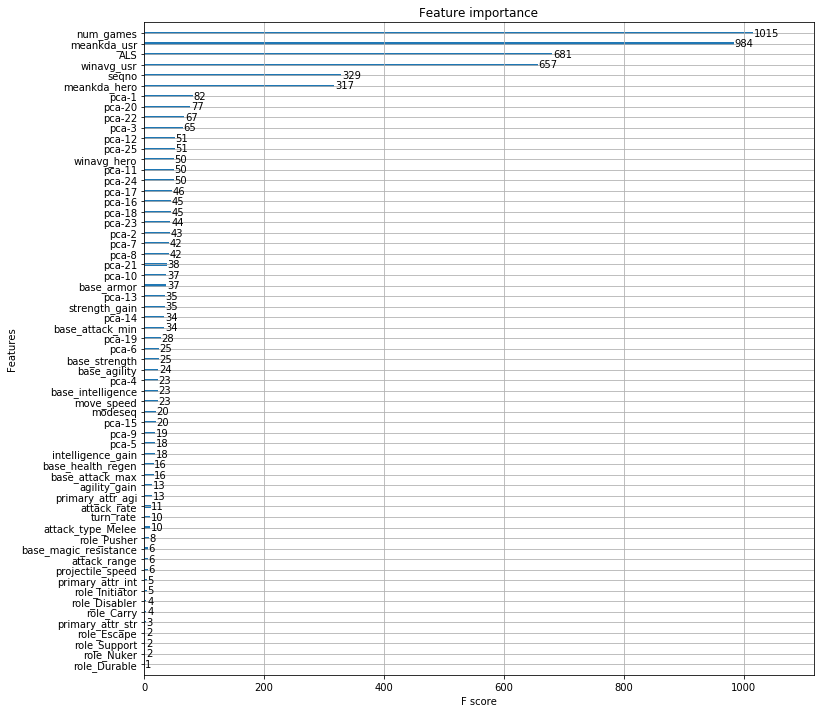

In [68]:
#%%##### XGBoost ########################
print('Training XGBoost.')
model = xgb.XGBRegressor(max_depth=5,
                         colsample_bylevel=1,
                         objective="reg:linear",
                         learning_rate=0.1,
                         colsample_bytree = 1,
                         n_estimators=200,
                         silent= 1,
                         nthread=-1)
model.fit(train[feature] ,ytrain)

trainPred,testPred = model.predict(train[feature]),model.predict(test[feature])
trainRMSE,testRMSE = RMSE(ytrain,trainPred) , RMSE(ytest,testPred)
print "Train RMSE : %f  Test RMSE : %f"%(trainRMSE, testRMSE)
#%%
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, ax=ax,max_num_features=100)
pylab.show()

In [69]:
ydata = finaldata_.pop('kda_ratio')

In [70]:
xgdmat = xgb.DMatrix(finaldata_[feature], ydata)
our_params = {'eta': 0.1, 'seed':0, 'colsample_bylevel': 1,'colsample_bytree': 0.8, 
             'objective': 'reg:linear', 'max_depth':5, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 500, nfold = 5,
                metrics = ['rmse'],  early_stopping_rounds = 200,verbose_eval = True)

[0]	train-rmse:3344.44+2.00809	test-rmse:3344.58+8.32702
[1]	train-rmse:3023.06+3.14711	test-rmse:3023.6+9.02599
[2]	train-rmse:2733.43+2.74725	test-rmse:2734.35+8.53762
[3]	train-rmse:2475.43+1.73752	test-rmse:2476.51+9.1412
[4]	train-rmse:2245.45+1.40219	test-rmse:2246.72+9.20443
[5]	train-rmse:2038.29+0.78472	test-rmse:2039.82+7.70015
[6]	train-rmse:1853.28+1.31319	test-rmse:1855.43+8.14034
[7]	train-rmse:1689.75+1.63968	test-rmse:1692.57+8.83486
[8]	train-rmse:1543.05+2.44489	test-rmse:1546.41+9.62793
[9]	train-rmse:1412.34+2.35916	test-rmse:1416.14+9.53248
[10]	train-rmse:1296.58+3.19091	test-rmse:1301.2+9.67951
[11]	train-rmse:1193.34+2.63523	test-rmse:1198.61+9.09982
[12]	train-rmse:1102.69+1.57344	test-rmse:1108.49+8.19776
[13]	train-rmse:1022.87+1.27427	test-rmse:1029.4+7.95695
[14]	train-rmse:953.315+1.58308	test-rmse:960.962+7.58627
[15]	train-rmse:892.831+2.1888	test-rmse:901.508+6.99491
[16]	train-rmse:840.964+2.05067	test-rmse:850.498+7.98183
[17]	train-rmse:795.027+1.928

[142]	train-rmse:483.644+1.31058	test-rmse:530.986+10.6002
[143]	train-rmse:483.246+1.3225	test-rmse:530.812+10.5403
[144]	train-rmse:482.861+1.24224	test-rmse:530.62+10.5403
[145]	train-rmse:482.602+1.22431	test-rmse:530.526+10.5368
[146]	train-rmse:482.215+1.22156	test-rmse:530.288+10.6476
[147]	train-rmse:481.929+1.23845	test-rmse:530.16+10.64
[148]	train-rmse:481.686+1.24003	test-rmse:530.041+10.6949
[149]	train-rmse:481.194+1.27757	test-rmse:529.848+10.6668
[150]	train-rmse:480.955+1.1782	test-rmse:529.705+10.6869
[151]	train-rmse:480.622+1.1815	test-rmse:529.564+10.704
[152]	train-rmse:480.276+1.18148	test-rmse:529.453+10.6552
[153]	train-rmse:479.956+1.15539	test-rmse:529.325+10.6214
[154]	train-rmse:479.644+1.12051	test-rmse:529.183+10.543
[155]	train-rmse:479.386+1.12777	test-rmse:529.112+10.5579
[156]	train-rmse:479.091+1.08091	test-rmse:528.987+10.569
[157]	train-rmse:478.813+1.12277	test-rmse:528.838+10.5541
[158]	train-rmse:478.569+1.17417	test-rmse:528.736+10.5725
[159]	t

[282]	train-rmse:446.93+1.44509	test-rmse:516.147+9.72634
[283]	train-rmse:446.625+1.42707	test-rmse:516.042+9.63394
[284]	train-rmse:446.264+1.33295	test-rmse:515.938+9.69776
[285]	train-rmse:445.976+1.38241	test-rmse:515.804+9.69446
[286]	train-rmse:445.721+1.45789	test-rmse:515.647+9.71395
[287]	train-rmse:445.532+1.5299	test-rmse:515.554+9.66715
[288]	train-rmse:445.249+1.56317	test-rmse:515.454+9.70393
[289]	train-rmse:445.024+1.6184	test-rmse:515.339+9.70087
[290]	train-rmse:444.736+1.56689	test-rmse:515.214+9.73214
[291]	train-rmse:444.501+1.64326	test-rmse:515.163+9.7558
[292]	train-rmse:444.221+1.64512	test-rmse:515.046+9.7491
[293]	train-rmse:443.977+1.60005	test-rmse:514.985+9.77483
[294]	train-rmse:443.815+1.56255	test-rmse:514.919+9.78126
[295]	train-rmse:443.645+1.60133	test-rmse:514.862+9.73654
[296]	train-rmse:443.442+1.60368	test-rmse:514.727+9.75706
[297]	train-rmse:443.203+1.58228	test-rmse:514.628+9.7542
[298]	train-rmse:443.024+1.56482	test-rmse:514.585+9.74839
[29

[423]	train-rmse:418.485+1.83681	test-rmse:505.493+10.0392
[424]	train-rmse:418.258+1.91677	test-rmse:505.372+9.93752
[425]	train-rmse:418.104+1.91383	test-rmse:505.337+9.93728
[426]	train-rmse:417.957+1.90728	test-rmse:505.36+9.96363
[427]	train-rmse:417.79+1.92791	test-rmse:505.293+9.96001
[428]	train-rmse:417.619+1.92895	test-rmse:505.188+10.0233
[429]	train-rmse:417.409+1.94868	test-rmse:505.074+9.9743
[430]	train-rmse:417.218+1.99295	test-rmse:504.977+10.0149
[431]	train-rmse:417.034+1.97883	test-rmse:504.931+9.99774
[432]	train-rmse:416.872+1.98556	test-rmse:504.872+10.0061
[433]	train-rmse:416.71+2.0281	test-rmse:504.83+10.0052
[434]	train-rmse:416.556+2.06857	test-rmse:504.781+9.98927
[435]	train-rmse:416.391+2.03923	test-rmse:504.718+10.007
[436]	train-rmse:416.151+2.04461	test-rmse:504.634+9.98074
[437]	train-rmse:415.903+2.11723	test-rmse:504.551+9.99287
[438]	train-rmse:415.661+2.05502	test-rmse:504.443+9.93401
[439]	train-rmse:415.541+2.12176	test-rmse:504.412+9.93315
[440

In [71]:
# # Linear regression
# from sklearn import datasets, linear_model
# lm = linear_model.LinearRegression()
# model = lm.fit(train[feature], ytrain)
# predictions = lm.predict(test[feature])
# predictions_train = lm.predict(train[feature])
# print ' Train Score:', RMSE(predictions_train, ytrain)
# print ' Test Score:', RMSE(predictions, ytest)

In [72]:
# with full data
# ydata = finaldata_.pop('kda_ratio')
model.fit(finaldata_[feature] ,ydata)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1)

In [73]:
trainPred,testPred = model.predict(train[feature]),model.predict(test[feature])
trainRMSE,testRMSE = RMSE(ytrain,trainPred) , RMSE(ytest,testPred)
print "Train RMSE : %f  Test RMSE : %f"%(trainRMSE, testRMSE)

Train RMSE : 474.422197  Test RMSE : 447.074488


In [74]:
## Submission
finaltest_['predict_kda'] = model.predict(finaltest_[feature])
submit = pd.DataFrame(data=finaltest_.id, columns=['id'])
submit['kda_ratio'] = finaltest_['predict_kda']
submit['user_id'] = finaltest_['user_id']
submit = submit.sort_values(by='user_id')
submit = submit.drop(['user_id'], axis=1)

/home/harshit/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [75]:
submit.head()

,id,kda_ratio
405,3_53,2769.328369
156,4_17,3318.691406
138,9_51,2819.020264
507,10_54,4614.799316
1,15_74,4903.519043


In [42]:
submit.to_csv('submit_als_14_pca_10_rf_200_6depth_overfit1_500_300_once.csv', index=False)